In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 929710272419669043
 xla_global_id: -1]

In [17]:
master_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HealthCare/worldometer_coronavirus_daily_data_latest.csv')
master_df.head()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-2-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-2-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-2-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
3,2020-2-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
4,2020-2-19,Afghanistan,0.0,NaN,0.0,0.0,NaN


In [18]:
master_df.tail()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
152730,2022-1-01,Zimbabwe,214214.0,956.0,26786.0,5017.0,13.0
152731,2022-1-02,Zimbabwe,214878.0,664.0,26585.0,5032.0,15.0
152732,2022-1-03,Zimbabwe,216087.0,1209.0,25446.0,5047.0,15.0
152733,2022-1-04,Zimbabwe,217678.0,1591.0,24620.0,5078.0,31.0
152734,2022-1-05,Zimbabwe,219057.0,1379.0,24252.0,5092.0,14.0


In [19]:
master_df.shape

(152735, 7)

In [20]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152735 entries, 0 to 152734
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     152735 non-null  object 
 1   country                  152735 non-null  object 
 2   cumulative_total_cases   152735 non-null  float64
 3   daily_new_cases          145244 non-null  float64
 4   active_cases             147898 non-null  float64
 5   cumulative_total_deaths  145825 non-null  float64
 6   daily_new_deaths         129468 non-null  float64
dtypes: float64(5), object(2)
memory usage: 8.2+ MB


In [21]:
df = master_df[master_df['country'] == 'India']

In [22]:
df.fillna(0,inplace=True)

In [23]:
df.reset_index(drop=True,inplace=True)

In [24]:
df = df[df['daily_new_cases'] != 0]

In [25]:
df.reset_index(inplace=True,drop=True)

In [26]:
time = pd.date_range(start='3/2/2020',periods=674,freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['date','country'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [27]:
df = df[['daily_new_cases']]

In [28]:
df.head()

,daily_new_cases
time_stamp,
2020-03-02,3.0
2020-03-03,1.0
2020-03-04,22.0
2020-03-05,1.0
2020-03-06,1.0


In [29]:
df.tail()

,daily_new_cases
time_stamp,
2021-12-31,27553.0
2022-01-01,33750.0
2022-01-02,37379.0
2022-01-03,58097.0
2022-01-04,90928.0


In [30]:
plt.rcParams['figure.figsize'] = [15,8]

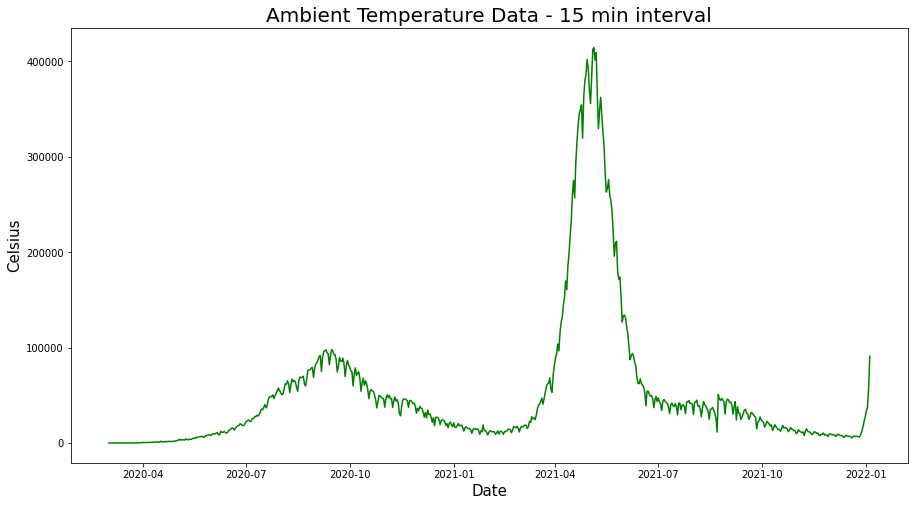

In [31]:
plt.plot(df,color='green')
plt.title('Ambient Temperature Data - 15 min interval',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Celsius',fontsize=15)
plt.show()

In [32]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [74]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['daily_new_cases'] = df['daily_new_cases'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [75]:
#Split data set into testing dataset and train dataset
train_size = 600
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 10
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [54]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(590, 10)
(590,)
(64, 10)
(64,)


In [36]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 6.7 MB/s 


In [37]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 128,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=36,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 13s]
val_mape: 2.945474147796631

Best val_mape So Far: 2.620034694671631
Total elapsed time: 00h 02m 30s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 4
units_0: 64
dropout: False
learning_rate: 0.00764309811403132
units_1: 48
units_2: 88
Dropout_rate: 0.30000000000000004
units_3: 8
Score: 2.620034694671631
Trial summary
Hyperparameters:
num_layers: 5
units_0: 96
dropout: False
learning_rate: 0.0014567430098165058
units_1: 96
units_2: 16
Dropout_rate: 0.1
units_3: 64
units_4: 96
units_5: 120
Score: 2.626635789871216
Trial summary
Hyperparameters:
num_layers: 3
units_0: 48
dropout: True
learning_rate: 0.0002711685988732404
units_1: 72
units_2: 16
Dropout_rate: 0.1
units_3: 120
units_4: 120
units_5: 104
Score: 2.6935133934020996
Trial summary
Hyperparameters:
num_layers: 5
units_0: 112
dropout: False
learning_rate: 0.0006488047268196734
units_1: 88
units_2: 40
Dropout_rate: 0.30000000000000004
units_3: 40
units_4: 48
units_5: 32
Score: 2.8258860111236572
Trial summary
Hyperparameters:

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dense_2 (Dense)             (None, 88)                4312      
                                                                 
 dense_3 (Dense)             (None, 8)                 712       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,857
Trainable params: 8,857
Non-trainable params: 0
_________________________________________________________________


In [38]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [76]:
model = Sequential()
model.add(Dense(512,activation='relu',input_dim = 10))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.0000564309811403132)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 300)

Epoch 1/300
17/17 [==============================] - 27s 17ms/step - loss: 72.0097 - mape: 72.0097 - val_loss: 48.1124 - val_mape: 48.1124
Epoch 2/300
17/17 [==============================] - 0s 7ms/step - loss: 31.7577 - mape: 31.7577 - val_loss: 5.2881 - val_mape: 5.2881
Epoch 3/300
17/17 [==============================] - 0s 7ms/step - loss: 9.4355 - mape: 9.4355 - val_loss: 9.0681 - val_mape: 9.0681
Epoch 4/300
17/17 [==============================] - 0s 7ms/step - loss: 7.9053 - mape: 7.9053 - val_loss: 8.7528 - val_mape: 8.7528
Epoch 5/300
17/17 [==============================] - 0s 7ms/step - loss: 7.3328 - mape: 7.3328 - val_loss: 5.5986 - val_mape: 5.5986
Epoch 6/300
17/17 [==============================] - 0s 7ms/step - loss: 6.6195 - mape: 6.6195 - val_loss: 5.2325 - val_mape: 5.2325
Epoch 7/300
17/17 [==============================] - 0s 7ms/step - loss: 6.1385 - mape: 6.1385 - val_loss: 4.6558 - val_mape: 4.6558
Epoch 8/300
17/17 [==============================] - 0s 10ms/

In [77]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [78]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 2.38 
Test MAPE : 2.49 


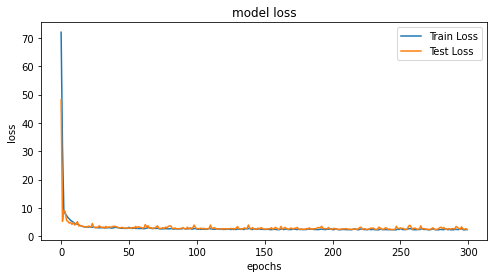

In [79]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [45]:
import seaborn as sns

In [80]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(590,654)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

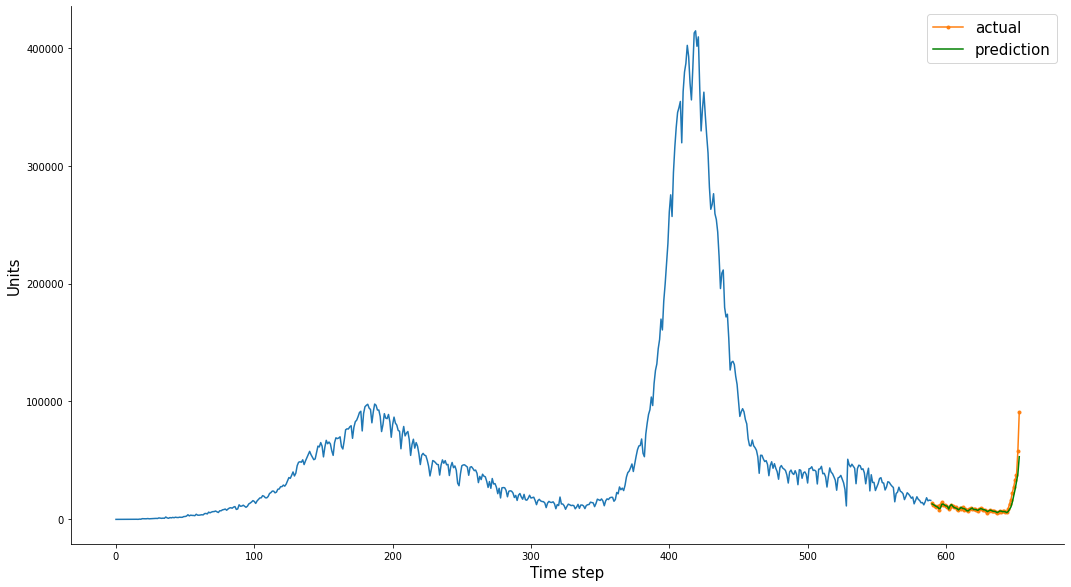

In [81]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)